# Генерация описаний к фотографиям людей

https://www.kaggle.com/competitions/yaic-fu-dl23/overview

Цель соревнования заключается в разработке модели, способной самостоятельно анализировать визуальный контент и формулировать смысловые и качественные подписи, отражающие сцены, действия и эмоции на фотографиях. Ваши решения будут оцениваться на основе их точности.

**Разделение данных**\
Для обучения модели участникам предоставлена обучающая выборка, содержащая разнообразные изображения с соответствующими эталонными подписями. В процессе оценки моделей используется тестовая выборка, которая в свою очередь разделена на две части: публичную и приватную.

* Обучающая выборка: Данные, на которых участники обучают свои модели.
* Публичная тестовая выборка: Часть данных, использованная для оценки моделей в режиме реального времени по метрике BLEU. Результаты на публичной тестовой выборке будут видны участникам.
* Приватная тестовая выборка: Вторая часть тестовых данных, метрика на которой останется невидимой до завершения соревнования. Результаты на приватной тестовой выборке будут использоваться для окончательной оценки и определения победителей.

# Импорт библиотек

In [ ]:
pip install kaggle

In [ ]:
import os
# {"username":"nastyakon","key":"7bd3facd6444e3965f8edb7e0a85e81c"}
os.environ["KAGGLE_USERNAME"] = "nastyakon"
os.environ["KAGGLE_KEY"] = "7bd3facd6444e3965f8edb7e0a85e81c"

In [ ]:
# kaggle competitions download -c yaic-fu-dl23

In [ ]:
# !pip install pymorphy2

In [ ]:
from nltk import bleu
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer("\w+")
from pymystem3 import Mystem

m = Mystem()

# import pymorphy2

# morph = pymorphy2.MorphAnalyzer()

from torchtext.vocab import Vocab
from torchtext.vocab import build_vocab_from_iterator

from zipfile import ZipFile
from PIL import Image
from torchvision.datasets import ImageFolder
import torchvision.transforms.v2 as T_v
import torchtext.transforms as T_t

import torch as th
import pandas as pd, numpy as np
import torch.nn as nn
import torch.optim as optim

from  torch.utils.data import DataLoader
from torchvision.models import vgg16

# Загрузка датасета

In [ ]:
zipfile = ZipFile("/content/drive/MyDrive/пм21_финашка/3 курс/Deep learning/контест №2/images.zip", "r")
zipfile.extractall('/content/images')

In [ ]:
names_img = zipfile.namelist()[1:]
names = []
for i in  zipfile.namelist()[1:]:
  names.append(i[7:len(i)-4])

In [ ]:
Image.open(zipfile.namelist()[0]+zipfile.namelist()[1])

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/пм21_финашка/3 курс/Deep learning/контест №2/train.csv')
train.head()

,image,caption
0,f2d1a9ab8c8f47b2bb9def897d0f5159,Молодая женщина танцует под музыку в наушниках.
1,f2d1a9ab8c8f47b2bb9def897d0f5159,Женщина моложе танцует под музыку в наушниках.
2,d2bcae6b014e465cabc617b920a4e949,Механик чинит машину в гараже.
3,d2bcae6b014e465cabc617b920a4e949,Механик занимается ремонтом автомобиля в гараже.
4,d2bcae6b014e465cabc617b920a4e949,Работник автосервиса чинит машину в гараже.


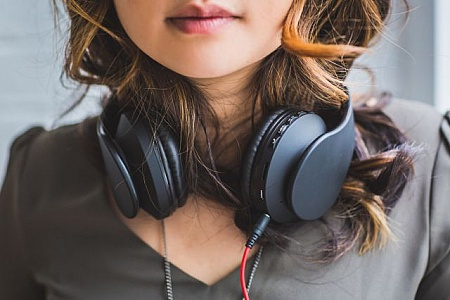

In [ ]:
Image.open('images/images/000cda48a2574b7398dfe16934cae467.jpg')

In [ ]:
train.duplicated().sum()

0

In [ ]:
train['image'].duplicated().sum(), train['caption'].duplicated().sum()

# в столбце Image 2147 повторяющихся изображений, для которых различный текст в столбце caption

(2147, 7)

In [ ]:
train.shape

(3402, 2)

In [ ]:
train = train.groupby('image')['caption'].apply(lambda x: ' '.join(x)).reset_index()
train

# удалили  дубликаты столбца Image

,image,caption
0,000cda48a2574b7398dfe16934cae467,Женщина с черными наушниками обвязанными вокру...
1,001653d6d17c48cc80f807e48a9f8b03,"Когда Джонни был младенцем, он увлекся водой....."
2,0049288a3c514c5b926f6cd062463a26,"Маленький ребенок кривит глаза, высовывает язы..."
3,00898e3b22fe4c6b9df777a5f054ee46,Молодой мужчина в красном свитере прислоняется...
4,00cbb18a798e4cd59674bdefd4659c82,Зак Александр расслабляется на круге. Улыбающи...
...,...,...
1250,feec5baa2fa347e695147188257357cf,"Молодой бизнесмен, держащий кошелек с деньгами..."
1251,ff04def294b4429295ec0000b5980898,Черно-белая перспективная фотография сидящего ...
1252,ff52c7dd74c84489b96ee695a0ad09c1,Профессиональная камера со множеством объектив...
1253,ffd57a9d1f204ed3b0680ef1b477972d,Фотоиллюстрация: мужчина делает покупки в совр...


In [ ]:
# лемматизация

train['caption'] = train['caption'].apply(lambda x:  ' '.join([i for i in m.lemmatize(x) if i not in [' ', '\n']]))
train.head()



In [ ]:
train['caption'] = train['caption'].apply(lambda x: list(np.unique(tokenizer.tokenize(x.lower()))))
train.shape

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/пм21_финашка/3 курс/Deep learning/контест №2/test.csv')
test.head()

In [ ]:
sample_sub = pd.read_csv('/content/drive/MyDrive/пм21_финашка/3 курс/Deep learning/контест №2/sample_submission.csv')
sample_sub.head()

In [ ]:
train['image'] = train['image'].apply(lambda x: "images/images/"+ x +".jpg")
test['image'] = test['image'].apply(lambda x: "images/images/"+ x +".jpg")
sample_sub['image'] = sample_sub['image'].apply(lambda x: "images/images/"+ x +".jpg")
# train['caption'] = train['caption'].apply(lambda x: np.unique([pymorphy2.MorphAnalyzer().parse(i)[0].normal_form for i in x]))

train.head()

In [ ]:
corpus = []
for i in train['caption']:
  corpus.append(i)
corpus

In [ ]:
maxlen = max([len(i) for i in corpus])
maxlen

## Вокаб

In [ ]:
token = ['<PAD>', '<SOS>', '<EOS>']

vocab = build_vocab_from_iterator(
    corpus,
    specials = token
)
vocab.get_stoi()

In [ ]:
len(vocab)

# Определение датасета

In [ ]:
class ImageCaptionDataset:
  def __init__(self, df, corpus = None, vocab = None):

    self.vocab = vocab
    self.corpus = corpus
    self.transform_image = T_v.Compose(
    [
        T_v.Resize((450,450)),
        T_v.ToTensor(),
        T_v.Normalize(mean = [0,0,0], std = [1,1,1])
    ]
    )
    if self.vocab is not None:
      self.transform_caption = T_t.Sequential(
          T_t.VocabTransform(self.vocab),
          T_t.AddToken(token = self.vocab.get_stoi()['<SOS>'], begin = True),   # в начало
          T_t.AddToken(token = self.vocab.get_stoi()['<EOS>'], begin = False),  # в конец
          T_t.ToTensor(padding_value = self.vocab.get_stoi()['<PAD>']) ,  # заполнение 0
          T_t.PadTransform(max_length = maxlen+2, pad_value =  self.vocab.get_stoi()['<PAD>'])  # заполнение до фиксированной длины
      )


    # self.caption = df['caption'].values
    self.name_img = df['image'].values
    # self.ds = ImageFolder(image_file, transform = self.transform)

  def __getitem__(self, idx):
    if type(idx) == int:
      idx = slice(idx, idx+1)
    if self.corpus is not None:
        caption = self.transform_caption(self.corpus[idx])
    name_img = self.name_img[idx]


    images = []
    for i in name_img:
      try:
        image = self.transform_image(Image.open(i))
        images.append(image)
      except FileNotFoundError:
        pass
    if self.corpus is not None:
      return th.stack(images).squeeze(0), caption.squeeze(0)
    else:
      return images


  def __len__(self):
    return len(self.name_img)

In [ ]:
ImageCaptionDataset(df = train, corpus = corpus, vocab = vocab)[:10]

In [ ]:
train_ds = ImageCaptionDataset(df = train, corpus = corpus, vocab = vocab)

In [ ]:
test_ds = ImageCaptionDataset(df = test)
test_ds[0]

In [ ]:
train_ds[0][0].shape

## DataLoader

In [ ]:
train_loader = DataLoader(train_ds, batch_size = 64, shuffle = True)

In [ ]:
for x, y in train_loader:
  print(x.shape, y.shape)   # batch_size x rgb x h x w


# 1 с использованием моделей Hugging Face


In [ ]:
# pip install sentencepiece

In [ ]:
# from transformers import pipeline

# caption_model = pipeline("image-to-text", model="Salesforce/blip-image-captioning-large", device = 'cuda')
# translate = pipeline("translation", model="Helsinki-NLP/opus-mt-en-ru", device= 'cuda')

# # Load model directly
# # from transformers import AutoProcessor, AutoModelForSeq2SeqLM, BartConfig

# # processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
# # model_config = BartConfig.from_pretrained("Salesforce/blip-image-captioning-large")
# # model = AutoModelForSeq2SeqLM.from_pretrained("Salesforce/blip-image-captioning-large", config=model_config)

In [ ]:

# # Use a pipeline as a high-level helper
# from transformers import pipeline

# translate = pipeline("translation", model="Helsinki-NLP/opus-mt-en-ru", device= 'cuda')

In [ ]:
# captions = []
# for i in train['image'].values[:10]:
#   captions.append(translate(caption_model(i, max_new_tokens = 50)[0]['generated_text'])[0]['translation_text'])

# captions

In [ ]:
# orig = [[i] for i in train['caption'].apply(lambda x: " ".join(x))[:10].values]
# orig

In [ ]:
from torchvision import models
import torch.nn as nn

In [ ]:
image_encoder = models.resnet18(pretrained=True)
image_encoder

In [ ]:
list(image_encoder.children())[:-1]

In [12]:
model = ImageCaptionGenerator(vocab_size, embedding_dim, hidden_dim, num_layers)
model

NameError: ignored

In [10]:
class ImageCaptionGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(ImageCaptionGenerator, self).__init__()
        self.image_encoder = models.resnet18(pretrained=True)
        self.image_encoder = nn.Sequential(*list(self.image_encoder.children())[:-1]) # без последнего слоя( (fc): Linear(in_features=512, out_features=1000, bias=True))
        self.caption_encoder = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers)   # рекуррентный слой
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, image, caption):
        features = self.image_encoder(image)  # обработка изображений
        features = th.flatten(features, start_dim=1)
        embedded_caption = self.caption_encoder(caption)   # обработка текста
        output, _ = self.rnn(embedded_caption)
        output = self.fc(output)
        return output


In [ ]:
# Задание параметров модели
vocab_size = len(vocab)
embedding_dim = 256
hidden_dim = 512
num_layers = 2

# Создание экземпляра модели
model = ImageCaptionGenerator(vocab_size, embedding_dim, hidden_dim, num_layers).cuda()

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
th.cuda.empty_cache()
th.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 323395 KiB |  11585 MiB | 178729 MiB | 178413 MiB |\n|       from large pool | 316574 KiB |  11578 MiB | 178683 MiB | 178374 MiB |\n|       from small pool |   6821 KiB |     13 MiB |     45 MiB |     38 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 323395 KiB |  11585 MiB | 178729 MiB | 178413 MiB |\n|       from large pool | 316574 KiB |  11578 MiB |

In [ ]:

# model = ImageCaptionGenerator(vocab_size = len(vocab), embedding_dim = 150, hidden_dim = 8, num_layers = 5).cuda()

# model(next(iter(train_loader))[0].cuda(), next(iter(train_loader))[1].cuda())

In [ ]:
n_epochs = 50

preds, target = [], []
# Цикл обучения модели
for epoch in range(n_epochs):
    for images, captions in train_loader:

        images = images.cuda()
        captions = captions.cuda()

        output = model(images, captions)

        # Расчет функции потерь
        loss = criterion(output.view(-1, vocab_size), captions.view(-1))

        # Обратное распространение ошибки и обновление весов
        loss.backward()
        # Обнуление градиентов
        optimizer.zero_grad()
        optimizer.step()

    #     # Вывод прогресса обучения
    # # if (epoch+1) % 100 == 0:

    #     out = output.argmax(dim=2)
    #     print(out.shape, output.shape)
    #     print(out)

    #     for i in range(len(out)):
    #         batch_preds = []
    #         for j in out[i]:
    #             if vocab.get_itos()[j] not in ['<SOS>', '<EOS>', '<UNK>']:
    #                 batch_preds.append(vocab.get_itos()[j])
    #         preds.append(" ".join(batch_preds))

    #     for i in range(len(captions)):
    #         batch_target = []
    #         for j in captions[i]:
    #             if vocab.get_itos()[j] not in ['<SOS>', '<EOS>', '<PAD>', '<UNK>']:
    #                 batch_target.append(vocab.get_itos()[j])
    #         target.append([" ".join(batch_target)])



    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 7.8896
Epoch [2/50], Loss: 7.8896
Epoch [3/50], Loss: 7.8890
Epoch [4/50], Loss: 7.8883
Epoch [5/50], Loss: 7.8868
Epoch [6/50], Loss: 7.8905
Epoch [7/50], Loss: 7.8902
Epoch [8/50], Loss: 7.8920
Epoch [9/50], Loss: 7.8907
Epoch [10/50], Loss: 7.8881
Epoch [11/50], Loss: 7.8903
Epoch [12/50], Loss: 7.8912
Epoch [13/50], Loss: 7.8903
Epoch [14/50], Loss: 7.8901
Epoch [15/50], Loss: 7.8927
Epoch [16/50], Loss: 7.8878
Epoch [17/50], Loss: 7.8905
Epoch [18/50], Loss: 7.8918
Epoch [19/50], Loss: 7.8889
Epoch [20/50], Loss: 7.8924
Epoch [21/50], Loss: 7.8891
Epoch [22/50], Loss: 7.8893
Epoch [23/50], Loss: 7.8874
Epoch [24/50], Loss: 7.8908
Epoch [25/50], Loss: 7.8896
Epoch [26/50], Loss: 7.8913
Epoch [27/50], Loss: 7.8892
Epoch [28/50], Loss: 7.8882
Epoch [29/50], Loss: 7.8921
Epoch [30/50], Loss: 7.8883
Epoch [31/50], Loss: 7.8888
Epoch [32/50], Loss: 7.8903
Epoch [33/50], Loss: 7.8885
Epoch [34/50], Loss: 7.8900
Epoch [35/50], Loss: 7.8890
Epoch [36/50], Loss: 7.8881
E

In [ ]:
preds[:10]

In [ ]:
target[:10]

In [ ]:
# import torch
th.cuda.empty_cache()

In [ ]:

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input):
        embedded = self.embedding(input.long())
        output, hidden = self.lstm(embedded)
        return output, hidden

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output, hidden = self.lstm(embedded, hidden)
        output = self.fc(output)
        return output, hidden

class ImageCaptionModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(ImageCaptionModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input, target):
        encoder_output, encoder_hidden = self.encoder(input)

        decoder_input = target[:, :-1]
        decoder_hidden = encoder_hidden

        decoder_output, _ = self.decoder(decoder_input, decoder_hidden)

        return decoder_output

# Задаем размеры входов и выходов модели
input_size = len(vocab)
output_size = len(vocab)
hidden_size = 256

# Создаем объекты модели, энкодера и декодера
encoder = Encoder(input_size, hidden_size)
decoder = Decoder(hidden_size, output_size)

# Создаем объект модели
model = ImageCaptionModel(encoder, decoder)

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Тренировка модели
for images, captions in train_loader:
    optimizer.zero_grad()

    # Прямой проход через модель
    outputs = model(images, captions)

    # Вычисление потерь
    loss = criterion(outputs.view(-1, output_size), captions[:, 1:].contiguous().view(-1))

    # Обратное распространение
    loss.backward()
    optimizer.step()

In [ ]:
import torch.nn as nn
import torchvision.models as models

# Энкодер - предварительно обученная сверточная нейронная сеть
class ImageEncoder(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(ImageEncoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

    def forward(self, images):
        out = self.resnet(images)
        out = self.adaptive_pool(out)
        out = out.permute(0, 2, 3, 1)
        return out

# Декодер - RNN для генерации текстовых подписей
class CaptionDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(CaptionDecoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [ ]:
import torchvision.models as models
models.resnet152()

In [ ]:
next(iter(train_loader))[0].shape


In [ ]:
example_batch = next(iter(train_loader))

image, captions = example_batch[0].cuda(), example_batch[1].cuda()

encoder = CNN(embed_size = 512).cuda()
decoder = RNN(input_size = 512, hidden_size = 512, embedding_dim=512, vocab_size = len(vocab)).cuda()

features = encoder(image)
print(features.shape) # batch_size x 512
print(captions.shape)
embed = decoder(features, captions.permute(1,0))

# print("Image Transformation: ", image.shape, " --> ", features.shape)
# print("Captions Transformation: ", captions.shape, " --> ", embed.shape)

In [ ]:
for x, y in train_loader:
  out = model(x.cuda())
  break

сначала сделать сегментацию, потом трансформер

In [ ]:
model = vgg16()
model

In [ ]:
test

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image

# Определяем класс Dataset для работы с данными
class ImageCaptionDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_id = self.annotations.iloc[idx, 0]
        img_name = f"{self.root_dir}/{img_id}.jpg"
        image = Image.open(img_name)
        caption = self.annotations.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, caption


In [ ]:
# Определим процесс обучения модели
def train_model(encoder, decoder, criterion, optimizer, data_loader, num_epochs):
    for epoch in range(num_epochs):
        for images, captions in data_loader:
            images = images.to(device)
            captions = captions.to(device)

            # Обнуляем градиенты
            optimizer.zero_grad()

            # Получаем выходы от энкодера
            features = encoder(images)

            # Подаем выходы энкодера на вход декодеру
            outputs = decoder(features, captions)

            # Рассчитываем ошибку
            loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

            # Обратное распространение ошибки и шаг оптимизации
            loss.backward()
            optimizer.step()

            # Выводим информацию о процессе обучения
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

# Определим процесс оценки модели
def evaluate_model(encoder, decoder, data_loader):
    # ...
    # Здесь вы можете определить код для оценки качества модели, например, расчет метрик BLEU или CIDEr
    # ...

# Определим гиперпараметры и загрузим данные
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
dataset = ImageCaptionDataset(csv_file='annotations.csv', root_dir='image', transform=transform)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Определим модель, функцию потерь и оптимизатор
encoder = ImageEncoder()
decoder = CaptionDecoder(embed_size, hidden_size, vocab_size)
encoder.to(device)
decoder.to(device)
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.embed.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

# Обучение модели
train_model(encoder, decoder, criterion, optimizer, data_loader, num_epochs)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

# Encoder (предварительно обученная CNN)
class ImageEncoder(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(ImageEncoder, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

    def forward(self, images):
        out = self.resnet(images)  # (batch_size, 2048, image_size, image_size)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out

# Decoder (RNN)
class CaptionDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(CaptionDecoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

# Собираем энкодер и декодер
embed_size = 256
hidden_size = 512
vocab_size = len(vocab)  # размер словаря для текстовых подписей
encoder = ImageEncoder()
decoder = CaptionDecoder(embed_size, hidden_size, vocab_size)
